Digit classification

In [7]:
# Importing important imports here:
import torch 
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import torch.utils.data as dset

from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch.optim as optim

# Set globals

DEVICE = "mps" # (set "cuda:0" if using Cuda, if all else fails use "cpu"..)
USING_GPU = True 
CONTINUE_TRAINING = False

BATCH_SIZE = 128
NO_EPOCHS = 50


Import/select data

In [8]:
transform = transforms.Compose([
    transforms.Resize(28),
    # transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    ]
)

trainSet = datasets.MNIST(root='MNIST', download=True, train=True, transform=transform)
testSet = datasets.MNIST(root='MNIST', download=True, train=False, transform=transform)

trainLoader = dset.DataLoader(trainSet, batch_size=BATCH_SIZE, shuffle=True)
testLoader = dset.DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=False)

Visualize data

In [9]:
#Visualize

Model definition

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1,64,5,stride=(1,1))
        
        self.pool1 = nn.MaxPool2d(2,stride=2,padding=0,dilation=1,ceil_mode=False)
        
        self.conv2 = nn.Conv2d(64,64,5,stride=(1,1))

        self.pool2 = nn.MaxPool2d(2,stride=2,padding=0,dilation=1,ceil_mode=False)
        
        self.fc2 = nn.Linear(1024, 43, bias=True)

    def forward(self, x):
        
        x = self.conv1(x)
        x = F.elu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.elu(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)

        x = self.fc2(x)
        
        return x
    
cnn = CNN()

if (USING_GPU):
    cnn.to(DEVICE)

if (CONTINUE_TRAINING):
    cnn.load_state_dict(torch.load('digits_naive'))
  
print(cnn)

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=1024, out_features=43, bias=True)
)


Plot loss function

In [11]:
def plot_loss(data_dict):    
    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title("Cross entropy loss")
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.xlim([0, NO_EPOCHS])
    plt.show()

Train model and plot loss

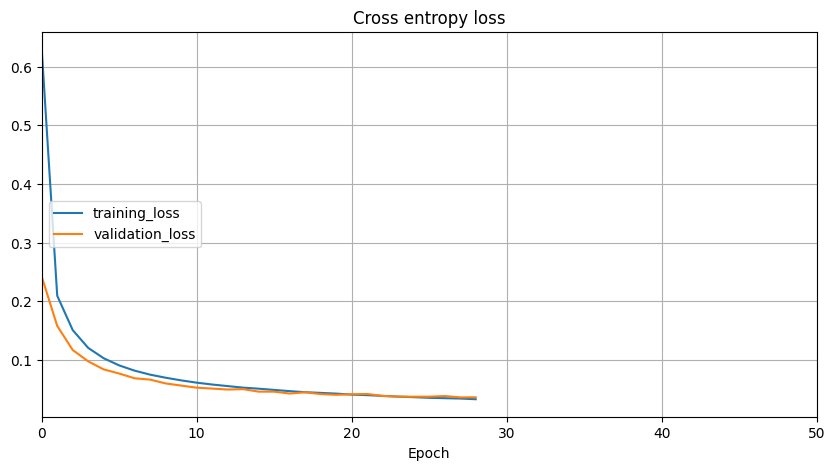

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001, eps=0.1)

dataDict = collections.defaultdict(list)

for epoch in range(NO_EPOCHS):  # Loop over the dataset multiple times

    # Train model on train data
    step_loss = []
    for i, data in enumerate(trainLoader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        if (USING_GPU):
          inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
        else:
          inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        step_loss.append(loss.item())
    
    # Calculate validation loss
    validationStep_loss = []
    cnn.eval()     # Optional when not using Model Specific layer
    for i, data in enumerate(testLoader):

        if (USING_GPU):
          inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
        else:
          inputs, labels = data        
        
        # Forward Pass
        outputs = cnn(inputs)
        # Find the Loss
        validation_loss = criterion(outputs, labels)
        # Calculate Loss
        validationStep_loss.append(validation_loss.item())
    
    #plot losses
    dataDict['training_loss'].append(np.array(step_loss).mean())
    dataDict['validation_loss'].append(np.array(validationStep_loss).mean())
    plot_loss(dataDict)
        


Evalueate model accuracy

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testLoader:
        if (USING_GPU):
          images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
        else:
          images, labels = data
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on test images: 66.89 %


Save model

In [ ]:
torch.save(cnn.state_dict(), 'digits')